In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
def regroup(data, freq='W'):
    o = data['Open'].groupby(by=pd.Grouper(freq=freq)).first()
    c = data['Close'].groupby(by=pd.Grouper(freq=freq)).last()
    h = data['High'].groupby(by=pd.Grouper(freq=freq)).max()
    l = data['Low'].groupby(by=pd.Grouper(freq=freq)).min()
    v = data['Volume'].groupby(by=pd.Grouper(freq=freq)).sum()
    ac = data['Adj Close'].groupby(by=pd.Grouper(freq=freq)).last()
    n = pd.concat([o, h, l, c, ac, v], axis=1)
    n.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    return n

## Download Data

In [3]:
import os

cwd = os.getcwd()
# Check if price data have been saved
price_data = os.path.join(cwd, "price_data")
if not os.path.exists(price_data):
    # Getting the Nasdaq 100 ticker symbols from Wikipedia
    nas_df = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
    tickers = nas_df.Ticker.to_list()
    # Download the Nasdaq 100 Adjusted Close price data with yfinance
    df = yf.download(tickers, start="2010-01-01")
    # Create price_data directory
    os.makedirs(price_data)
    # Save a copy of the dataframe to price_data directory
    df.to_csv(os.path.join(price_data, "Nasdaq-100.csv"))
else:
    # Load the Nasdaq-100.csv
    df = pd.read_csv(os.path.join(price_data, "Nasdaq-100.csv"), 
                     header=[0,1], index_col=0)
    df.index = pd.to_datetime(df.index)

## Monthly returns

In [4]:
sdf = df.swaplevel(axis=1)

In [5]:
data = sdf['TSLA'].dropna()

In [6]:
adj_close = data['Close']
buy_and_hold = adj_close.iloc[-1] / adj_close.iloc[0] - 1
max_profit = adj_close.max() / adj_close.iloc[0] - 1

print(f'Return while buy and hold: {buy_and_hold:.2f} x')
print(f'Return while sold at max high: {max_profit:.2f} x')

Return while buy and hold: 76.37 x
Return while sold at max high: 256.41 x


In [7]:
capital = 1000
base_cap = capital
num_share = 0 
max_share = 1000
holding = False
buy_at = 0
gain = []
tp = 0
sl = 0
nhigh = 0
pct_l = 1.015
pct_s = .985

for i in range(len(data.iloc[-20:])):
    da = data.iloc[i]
    if not holding:
        buy_at = da['Close']
        # calculate portfolio
        _share = capital // buy_at
        num_share = _share if _share < max_share else max_share
        capital -= buy_at * num_share
        # calculate risk and profit 
        tp = buy_at * pct_l
        sl = buy_at * pct_s
        holding = True
    else:
        # logic for risk and profit management
        sell_at = 0
        if da['Open'] < sl or da['Open'] > tp:
            sell_at = da['Open']
        elif da['High'] > tp:
            sell_at = tp
        elif da['Low'] < sl:
            sell_at = sl
        
        if sell_at != 0:
            gain.append(sell_at / buy_at)
            # calculate portfolio
            capital += sell_at * num_share
            # reset
            tp, sl = 0, 0
            nhigh = 0
            holding = False
            continue
        
        if da['High'] > nhigh:
            nhigh = da['High']
            tp = da['Close'] * pct_l
            sl = da['Close'] * pct_s
um_picks=[50, 25, 3]
if holding:
    capital += buy_at * num_share

ret = np.array(gain)
if len(ret) > 0:
    print(f"return: {ret.prod() - 1:.2f} x")
    print(f"num trades: {len(ret)}")
    print(f"win rate: {(ret > 1).mean()*100:.2f}%")
else:
    print("No trades")

return: 0.27 x
num trades: 10
win rate: 90.00%


## Picking

In [8]:
def get_date(date, s, e, include_end=False):
    if include_end:
        return date[(date >= s) & (date <= e)]
    return date[(date >= s) & (date < e)]

In [9]:
def get_top_picks(df, pct, end:int, p:int, num_picks=3):
    dr = pd.date_range(end=end, periods=p+1, freq='MS')[0]
    sym = df.loc[get_date(df.index, dr, end), 'Close'].dropna(axis=1).columns.to_list()
    ret = pct.loc[get_date(pct.index, dr, end), sym].prod()
    sym = ret.nlargest(num_picks).index.to_list()
    return sym

## Simulation

In [10]:
def simulate(data, pct_l=1.01, pct_s=.99, tracing=False):
    holding = False
    buy_at = 0
    gain = []
    tp = 0
    sl = 0
    nhigh = 0
    
    for i in range(len(data)):
        da = data.iloc[i]
        if not holding:
            buy_at = da['Close']
            # calculate risk and profit 
            tp = buy_at * pct_l
            sl = buy_at * pct_s
            holding = True
        else:
            # logic for risk and profit management
            sell_at = 0
            if da['Open'] < sl or da['Open'] > tp:
                sell_at = da['Open']
            elif da['High'] > tp:
                sell_at = tp
            elif da['Low'] < sl:
                sell_at = sl
            
            if sell_at != 0:
                gain.append(sell_at / buy_at)
                # reset
                tp, sl = 0, 0
                nhigh = 0
                holding = False
                continue
            
            if da['High'] > nhigh and tracing:
                nhigh = da['High']
                tp = da['Close'] * pct_l
                sl = da['Close'] * pct_s
    
    if holding:
        gain.append(data['Close'].iloc[-1] / buy_at)
    
    return np.prod(gain)

In [11]:
ms = df.groupby(by=pd.Grouper(freq='MS')).first().index
me = df.groupby(by=pd.Grouper(freq='M')).first().index

In [12]:
pct = (df['High'] / df['Close'].shift(1)).iloc[1:]

In [16]:
p = 3                   # Look back of N month
n = 1                   # Pick N ticker
p_l = 1.015             # Target profit percentage
p_s = .985              # Stop loss percentage
h = 12                  # Hidden data for N month use for forward test
apply_tracing = False   # Apply tracing limit or stop

#### Backtest

Return:  2672.16 x


<AxesSubplot: >

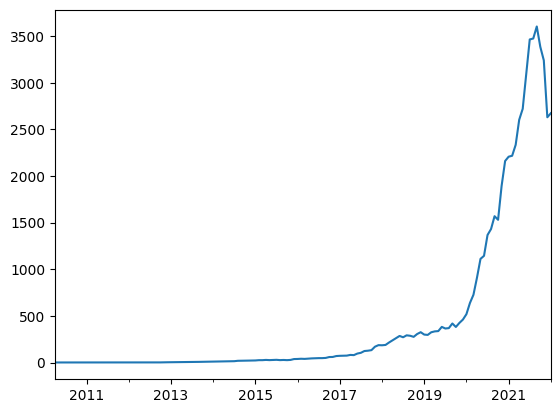

In [17]:
result = {}

for s, e in zip(ms[p:-h], me[p:-h]):
    # Top Picking
    top_picks = get_top_picks(df, pct, s, p, n)
    # Getting the current month's price data
    cur = sdf.loc[get_date(sdf.index, s, e, True), top_picks]
    ret = np.mean([simulate(cur[sym], 
                            p_l, 
                            p_s,
                            apply_tracing) for sym in top_picks])
    
    result[e] = {'return': ret,
                 'picks': top_picks}
    
### RESULT ###
result_df = pd.DataFrame.from_dict(result, orient='index')
print(f"Return: {result_df['return'].prod() - 1: .2f} x")
result_df['return'].cumprod().plot()

#### Forward test

Return:  1.08 x


<AxesSubplot: >

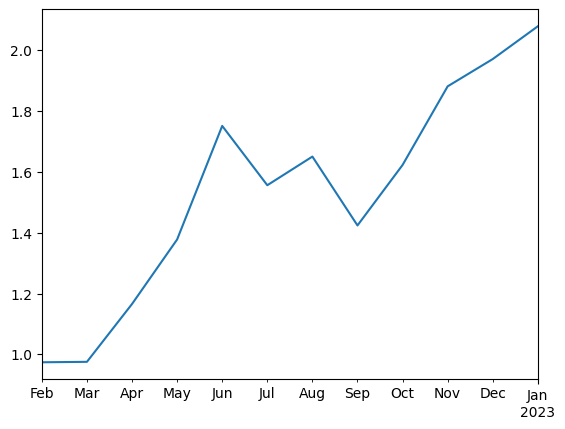

In [18]:
result = {}

for s, e in zip(ms[-h:], me[-h:]):
    # Top Picking
    top_picks = get_top_picks(df, pct, s, p, n)
    # Getting the current month's price data
    cur = sdf.loc[get_date(sdf.index, s, e, True), top_picks]
    ret = np.mean([simulate(cur[sym], 
                            p_l, 
                            p_s,
                            apply_tracing) for sym in top_picks])
    
    result[e] = {'return': ret,
                 'picks': top_picks}
    
### RESULT ###
result_df = pd.DataFrame.from_dict(result, orient='index')
print(f"Return: {result_df['return'].prod() - 1: .2f} x")
result_df['return'].cumprod().plot()